In [257]:
# Importing Required Libraries
import sys
import numpy as np # numpy for vector calculations
import matplotlib.pyplot as plt # For visualization and Results
import torch # import Pytorch
import torch.nn as nn # Neural Network
import torch.optim as optim #Neural Network Optimizer
import torch.nn.functional as F
from torch.distributions import Categorical, Normal # Categorical - Discrete Action Space , Normal - Continious Action Space
import gymnasium as gym  # enviroments or MDP
from collections import deque # to compute moving averages
import pickle #storing Policies
from typing import List, Tuple, Dict #readability and type safety
import time #benchmarking\logging
import copy

In [258]:
# Here we do seeding to ensure that during an episode run we are starting with the same inital state from the distribution Porivded by the MDP
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [259]:
# The experiments will be Run on Gpu if it detects otheriwse switch to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Given Below are the Implementations of the Policy class with Discrete Action Space with ReLU activation with 2 hidden layers the forward() function calculates the probability distribution(Categorical logits with softmax) of possible actions get_distribution() return the probability distribution and get_action() samples an action from this distribution.

In [260]:
class Discrete(nn.Module):
  
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int]):
        super(Discrete, self).__init__()
        layers = []
        input_dim = state_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())  # Changed to Tanh for better gradient flow
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, action_dim))
        self.network = nn.Sequential(*layers)
        
        # Better initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            nn.init.constant_(module.bias, 0.0)
    
    def forward(self, state):
        return self.network(state)
    
    def get_distribution(self, state):
        logits = self.forward(state)
        return Categorical(logits=logits)
    
    def get_action(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).to(device)
        if state.dim() == 1:
            state = state.unsqueeze(0)
        
        dist = self.get_distribution(state)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        if action.shape[0] == 1:
            return action.item(), log_prob.squeeze()
        return action, log_prob

Given Below is the implementation of Policy class for continous action space with ReLU activation forward() return the mean and standard deviation of the normal distribuiton defined on actions for a state s since actions are continious multivariate normals are used to model them  get_distribution() and get_action() do the same purpose as seen in the discrete case

In [261]:
class Continuous(nn.Module):

    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int]):
        super(Continuous, self).__init__()
        layers = []
        input_dim = state_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())  # Changed to Tanh
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, action_dim))
        self.mean_network = nn.Sequential(*layers)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
        # Better initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            nn.init.constant_(module.bias, 0.0)
    
    def forward(self, state):
        mean = self.mean_network(state)
        std = torch.exp(self.log_std).clamp(min=1e-3, max=50)  # Clamp std
        return mean, std
    
    def get_distribution(self, state):
        mean, std = self.forward(state)
        return Normal(mean, std)
    
    def get_action(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).to(device)
        if state.dim() == 1:
            state = state.unsqueeze(0)
        
        dist = self.get_distribution(state)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        if action.shape[0] == 1:
            return action.squeeze(0).cpu().numpy(), log_prob.squeeze()
        return action.cpu().numpy(), log_prob

Now another neural network is defined that will take care of approximating the value function V(s) which will allow us to compute Generalized Advantage Estimator to get a good low variance estimate of the gradient the Class is defined by a function compute_gae() which uses the rewards , the states , discount factor as well as lamda which is an Hyperparameter for advantage function estimation as seen in lectures the class outputs are the advantages for state s and an action a taken at that state as well as the discounter rewards , The next function conjugate_gradient() helps to solve the matrix equation Ax=b in order to find inverse/pseudo-inverses that come naturally in the solution of the optimization problem TRPO solves the alst three functions are utilized to flat the gradients computed as well as model paramters and set_flat_params() is used to update the parameters of the model . 

In [262]:
class ValueNetwork(nn.Module):
  
    def __init__(self, state_dim: int, hidden_sizes: List[int]):
        super(ValueNetwork, self).__init__()
        layers = []
        input_dim = state_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)
        

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=1.0)
            nn.init.constant_(module.bias, 0.0)
    
    def forward(self, state):
        return self.network(state).squeeze(-1)


def compute_gae(rewards, values, dones, next_value, gamma=0.99, lam=0.95):
    
    advantages = []
    gae = 0
    
    values_list = values.cpu().numpy().tolist()
    rewards_list = rewards if isinstance(rewards, list) else rewards.cpu().numpy().tolist()
    dones_list = dones if isinstance(dones, list) else dones.cpu().numpy().tolist()
    
    for t in reversed(range(len(rewards_list))):
        if t == len(rewards_list) - 1:
            next_val = next_value
        else:
            next_val = values_list[t + 1]
        
        delta = rewards_list[t] + gamma * next_val * (1 - dones_list[t]) - values_list[t]
        gae = delta + gamma * lam * (1 - dones_list[t]) * gae
        advantages.insert(0, gae)
    
    advantages = torch.FloatTensor(advantages).to(device)
    returns = advantages + values
    
    return advantages, returns


def flat_grad(grads):
    return torch.cat([grad.reshape(-1) for grad in grads])


def get_flat_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])


def set_flat_params(model, flat_params):
    prev_idx = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(flat_params[prev_idx:prev_idx + flat_size].view(param.size()))
        prev_idx += flat_size


def conjugate_gradient(Ax, b, n_steps=10, residual_tol=1e-10):
    x = torch.zeros_like(b).to(device)
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    
    for _ in range(n_steps):
        Ap = Ax(p)
        alpha = rdotr / (torch.dot(p, Ap) + 1e-8)
        x += alpha * p
        r -= alpha * Ap
        new_rdotr = torch.dot(r, r)
        
        if new_rdotr < residual_tol:
            break
        
        beta = new_rdotr / rdotr
        p = r + beta * p
        rdotr = new_rdotr
    
    return x

The TRPO class initializes the policy and value networks and sets hyperparameters like gamma, lambda, max_kl, damping as well the number of epochs . reset_trajectory() reset the stored states actions rewards and termination check as well the log probabilities , select_action() selects an action from the policy , store_transition stores actions and rewards and termination checks , compute_policy_loss() return the surrigate loss that is advantage times the ratio of new and old policy . compute_kl() returns the KL divergence of new and old policy it calculates the Kl Distribution and returns the mean of that hessian_vector_product() computes the hessian of kl divergence and multiply it by v so as to get Hv whihc will be used by conjugate gradient to get psuedo-inverse then line_search() is used for to ensure surrogate loss reduces and that Kl constraints are met the final function update() is used to update the parameters of actor and critic actor is updated via surrogate loss and critic via mean squared error loss 

In [263]:
class TRPOAgent:

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        is_continuous: bool,
        lr_value: float = 1e-3,
        gamma: float = 0.99,
        lam: float = 0.95,
        max_kl: float = 0.01,
        damping: float = 0.1,
        value_epochs: int = 5,
        hidden_sizes_policy: List[int] = None,
        hidden_sizes_value: List[int] = None,
        backtrack_coeff: float = 0.8,
        max_backtracks: int = 15,
        value_grad_clip: float = 0.5
    ):
        self.gamma = gamma
        self.lam = lam
        self.max_kl = max_kl
        self.damping = damping
        self.is_continuous = is_continuous
        self.value_epochs = value_epochs
        self.backtrack_coeff = backtrack_coeff
        self.max_backtracks = max_backtracks
        self.value_grad_clip = value_grad_clip
        
        if hidden_sizes_policy is None:
            hidden_sizes_policy = [64, 64]
        if hidden_sizes_value is None:
            hidden_sizes_value = [64, 64]
        
      
        if is_continuous:
            self.policy = Continuous(state_dim, action_dim, hidden_sizes_policy).to(device)
        else:
            self.policy = Discrete(state_dim, action_dim, hidden_sizes_policy).to(device)
        
      
        self.value_net = ValueNetwork(state_dim, hidden_sizes_value).to(device)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr_value)
        
        self.reset_trajectory()
    
    def reset_trajectory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.next_state = None
    
    def select_action(self, state):
        with torch.no_grad():
            action, log_prob = self.policy.get_action(state)
        
        self.states.append(state)
        self.log_probs.append(log_prob.item() if isinstance(log_prob, torch.Tensor) else log_prob)
        
        return action
    
    def store_transition(self, action, reward, done, next_state):
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.next_state = next_state
    
    def compute_policy_loss(self, states, actions, advantages, old_log_probs):
        dist = self.policy.get_distribution(states)
        
        if self.is_continuous:
            log_probs = dist.log_prob(actions).sum(dim=-1)
        else:
            log_probs = dist.log_prob(actions)
        
        ratio = torch.exp(log_probs - old_log_probs)
        surrogate_loss = (ratio * advantages).mean()
        
        return surrogate_loss
    
    def compute_kl(self, states, old_policy):
       
        dist = self.policy.get_distribution(states)
        old_dist = old_policy.get_distribution(states)
        
        if self.is_continuous:
            # KL(old || new) for trust region
            kl = torch.distributions.kl_divergence(old_dist, dist).sum(dim=-1)
        else:
            kl = torch.distributions.kl_divergence(old_dist, dist)
        
        return kl.mean()
    
    def hessian_vector_product(self, states, vector, old_policy):
        self.policy.zero_grad()
        kl = self.compute_kl(states, old_policy)
        
        grads = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
        flat_grad_kl = flat_grad(grads)
        
        kl_v = (flat_grad_kl * vector).sum()
        grads = torch.autograd.grad(kl_v, self.policy.parameters())
        flat_grad_grad_kl = flat_grad(grads)
        
        return flat_grad_grad_kl + vector * self.damping
    
    def line_search(self, states, actions, advantages, old_log_probs, old_policy, 
                   fullstep, expected_improve):
        
        old_params = get_flat_params(self.policy)
        old_loss = self.compute_policy_loss(states, actions, advantages, old_log_probs).item()
        
        for i in range(self.max_backtracks):
            stepfrac = self.backtrack_coeff ** i
            new_params = old_params + stepfrac * fullstep
            set_flat_params(self.policy, new_params)
            
            with torch.no_grad():
                new_loss = self.compute_policy_loss(states, actions, advantages, old_log_probs).item()
                kl = self.compute_kl(states, old_policy).item()
            
            actual_improve = new_loss - old_loss
            expected_improve_frac = expected_improve.item() * stepfrac
            improve_ratio = actual_improve / (expected_improve_frac + 1e-8)
            
            
            if kl <= self.max_kl * 1.5 and actual_improve > 0:
                return True, stepfrac, kl
        
       
        set_flat_params(self.policy, old_params)
        return False, 0.0, 0.0
    
    def update(self):
        
        if len(self.states) == 0:
            return 0.0, False, 0.0, 0.0
        
       
        states = torch.FloatTensor(np.array(self.states)).to(device)
        actions = torch.FloatTensor(np.array(self.actions)).to(device)
        rewards = self.rewards
        dones = self.dones
        old_log_probs = torch.FloatTensor(np.array(self.log_probs)).to(device)
        
       
        with torch.no_grad():
            values = self.value_net(states)
            if self.next_state is not None and not self.dones[-1]:
                next_state_tensor = torch.FloatTensor(self.next_state).unsqueeze(0).to(device)
                next_value = self.value_net(next_state_tensor).item()
            else:
                next_value = 0.0
        
       
        advantages, returns = compute_gae(rewards, values, dones, next_value, self.gamma, self.lam)
        
      
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
       
        value_losses = []
        for _ in range(self.value_epochs):
            value_pred = self.value_net(states)
            value_loss = F.mse_loss(value_pred, returns)
            
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), self.value_grad_clip)
            self.value_optimizer.step()
            
            value_losses.append(value_loss.item())
        
        
        old_policy = copy.deepcopy(self.policy)
        old_policy.eval()
        for param in old_policy.parameters():
            param.requires_grad = False
        
       
        loss = self.compute_policy_loss(states, actions, advantages, old_log_probs)
        grads = torch.autograd.grad(loss, self.policy.parameters(), retain_graph=False)
        policy_grad = flat_grad(grads)
        
       
        if policy_grad.norm() < 1e-8:
            self.reset_trajectory()
            return np.mean(value_losses), False, 0.0, 0.0
        
        
        def Ax(v):
            return self.hessian_vector_product(states, v, old_policy)
        
        stepdir = conjugate_gradient(Ax, policy_grad, n_steps=10)
        
        
        shs = 0.5 * torch.dot(stepdir, Ax(stepdir))
        lm = torch.sqrt(shs / (self.max_kl + 1e-8))
        fullstep = stepdir / (lm + 1e-8)
        
        
        expected_improve = torch.dot(policy_grad, fullstep)
        
        
        success, stepfrac, final_kl = self.line_search(
            states, actions, advantages, old_log_probs,
            old_policy, fullstep, expected_improve
        )
        
       
        self.reset_trajectory()
        
        return np.mean(value_losses), success, stepfrac, final_kl

The train_trpo is where the training begins we load the enviroment and the trpo class has all functionalies to train the agent. The agent interacts takes an action from policy and then stores the trajcectory information and updates the value network as well as the Actor via losses defined in the class evaluate agent() uses the trained policy and compute returns plot_single_enviroment() and print_summary_tables() are functionalities for logging purposes and visualization give plots for episodic rewards as well as moving average over 100 episodes summary table give the final evaluation mean and standard deviation of the policy . run_experiments() iterates over the 5 enviroments and perform the training and evaluation plots are summary are plotted as soon as one enviroment is trained and evaluated  


                    TRPO MULTI-ENVIRONMENT TRAINING


################################################################################
# STARTING: LunarLanderContinuous-v3
################################################################################


Training TRPO on LunarLanderContinuous-v3
State dimension: 8
Action dimension: 2
Action space type: Continuous
Max KL: 0.01
Value LR: 0.0005

Ep   50/2000 | R: -306.81 | Avg: -437.68 | VL: 520.8834 | KL: 0.00405 | Step: 1.00 | Time: 3s
Ep  100/2000 | R:  -20.15 | Avg: -328.45 | VL: 322.8927 | KL: 0.00600 | Step: 1.00 | Time: 8s
Ep  150/2000 | R: -220.99 | Avg: -159.37 | VL: 72.9194 | KL: 0.00776 | Step: 1.00 | Time: 22s
Ep  200/2000 | R: -176.16 | Avg: -126.36 | VL: 19.1039 | KL: 0.00951 | Step: 1.00 | Time: 31s
Ep  250/2000 | R: -121.94 | Avg: -156.50 | VL: 85.7257 | KL: 0.00710 | Step: 1.00 | Time: 39s
Ep  300/2000 | R: -122.67 | Avg: -131.61 | VL: 15.7835 | KL: 0.00771 | Step: 1.00 | Time: 50s
Ep  350/2000 | R:  -78.72 | Avg: -116.

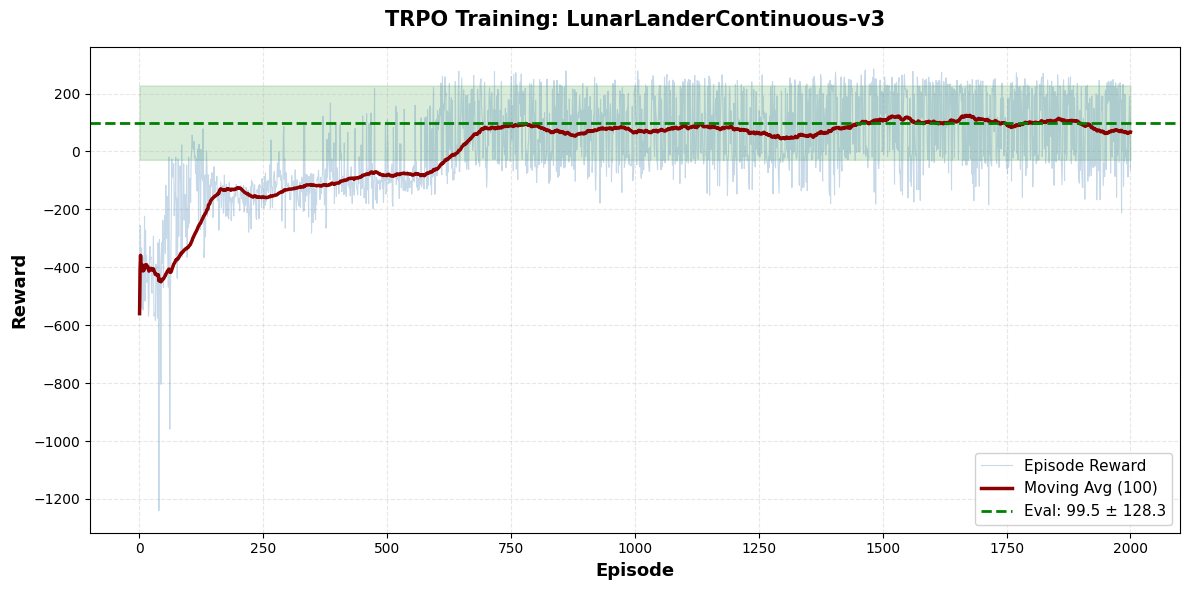


################################################################################
# STARTING: HalfCheetah-v5
################################################################################


Training TRPO on HalfCheetah-v5
State dimension: 17
Action dimension: 6
Action space type: Continuous
Max KL: 0.01
Value LR: 0.0005



KeyboardInterrupt: 

In [264]:
def train_trpo(
    env_name: str,
    num_episodes: int = 1000,
    lr_value: float = 1e-3,
    gamma: float = 0.99,
    max_kl: float = 0.01,
    damping: float = 0.1,
    backtrack_coeff: float = 0.8,
    max_backtracks: int = 15,
    value_grad_clip: float = 0.5,
    hidden_sizes_policy: List[int] = None,
    hidden_sizes_value: List[int] = None,
    print_freq: int = 50,
    max_steps: int = 1000
) -> Tuple[TRPOAgent, List[float], List[float]]:
   
    
    env = gym.make(env_name)
    
    state_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    
    if is_continuous:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n
    
    if hidden_sizes_policy is None:
        hidden_sizes_policy = [64, 64]
    if hidden_sizes_value is None:
        hidden_sizes_value = [64, 64]
    
    print(f"\n{'='*60}")
    print(f"Training TRPO on {env_name}")
    print(f"{'='*60}")
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    print(f"Action space type: {'Continuous' if is_continuous else 'Discrete'}")
    print(f"Max KL: {max_kl}")
    print(f"Value LR: {lr_value}")
    print(f"{'='*60}\n")
    
    agent = TRPOAgent(
        state_dim, action_dim, is_continuous,
        lr_value, gamma, 0.95, max_kl, damping, 5,
        hidden_sizes_policy, hidden_sizes_value,
        backtrack_coeff, max_backtracks, value_grad_clip
    )
    
    episode_rewards = []
    moving_avg_rewards = []
    
    start_time = time.time()
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed + episode)
        episode_reward = 0
        
        for step in range(max_steps):
            action = agent.select_action(state)
            
            if is_continuous:
                action_env = action.flatten() if isinstance(action, np.ndarray) else np.array([action]).flatten()
            else:
                action_env = action if isinstance(action, int) else int(action)
            
            next_state, reward, terminated, truncated, _ = env.step(action_env)
            done = terminated or truncated
            
            agent.store_transition(action, reward, done, next_state)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
       
        value_loss, success, stepfrac, kl = agent.update()
        
        episode_rewards.append(episode_reward)
        
        # Moving average
        window = min(100, episode + 1)
        moving_avg = np.mean(episode_rewards[-window:])
        moving_avg_rewards.append(moving_avg)
        
        if (episode + 1) % print_freq == 0:
            elapsed_time = time.time() - start_time
            print(f"Ep {episode + 1:4d}/{num_episodes} | "
                  f"R: {episode_reward:7.2f} | "
                  f"Avg: {moving_avg:7.2f} | "
                  f"VL: {value_loss:.4f} | "
                  f"KL: {kl:.5f} | "
                  f"Step: {stepfrac:.2f} | "
                  f"Time: {elapsed_time:.0f}s")
    
    env.close()
    
    print(f"\n{'='*60}")
    print(f"Training completed in {time.time() - start_time:.1f}s")
    print(f"Final average reward (last 100): {moving_avg_rewards[-1]:.2f}")
    print(f"{'='*60}\n")
    
    return agent, episode_rewards, moving_avg_rewards


def evaluate_agent(
    agent: TRPOAgent,
    env_name: str,
    num_episodes: int = 100,
    max_steps: int = 1000,
    render: bool = False
) -> Tuple[float, float]:
  
    
    env = gym.make(env_name, render_mode='human' if render else None)
    eval_rewards = []
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            with torch.no_grad():
                action, _ = agent.policy.get_action(state)
            
            if is_continuous:
                action_env = action.flatten() if isinstance(action, np.ndarray) else np.array([action]).flatten()
            else:
                action_env = action if isinstance(action, int) else int(action)
            
            next_state, reward, terminated, truncated, _ = env.step(action_env)
            done = terminated or truncated
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        eval_rewards.append(episode_reward)
    
    env.close()
    
    return np.mean(eval_rewards), np.std(eval_rewards)


def plot_single_environment(env_name: str, episode_rewards: List[float], 
                           moving_avg: List[float], eval_mean: float, 
                           eval_std: float, save_path: str = None):
   
    
    fig, ax = plt.subplots(figsize=(12, 6))
    episodes = range(1, len(episode_rewards) + 1)
    
    ax.plot(episodes, episode_rewards, alpha=0.3, label='Episode Reward', color='steelblue', linewidth=0.8)
    ax.plot(episodes, moving_avg, linewidth=2.5, label='Moving Avg (100)', color='darkred')
    
    ax.axhline(y=eval_mean, color='green', linestyle='--', linewidth=2, 
               label=f'Eval: {eval_mean:.1f} ± {eval_std:.1f}')
    ax.fill_between(episodes, eval_mean - eval_std, eval_mean + eval_std, 
                     color='green', alpha=0.15)
    
    ax.set_xlabel('Episode', fontsize=13, fontweight='bold')
    ax.set_ylabel('Reward', fontsize=13, fontweight='bold')
    ax.set_title(f'TRPO Training: {env_name}', fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved: {save_path}")
    
    plt.show()
    plt.close()


def run_experiments():
   
    
    environments = {
         
            'LunarLanderContinuous-v3': {
    'num_episodes': 2000,              
    'lr_value': 0.0005,                
    'max_kl': 0.01,                    
    'damping': 0.1,                   
    'backtrack_coeff': 0.5,           
    'max_backtracks': 20,              
    'value_grad_clip': 0.5,            
    'max_steps': 1000,
    'hidden_sizes_policy': [256, 256], 
    'hidden_sizes_value': [128, 128],
},
        'HalfCheetah-v5': {
            'num_episodes': 3000,
            'lr_value': 5e-4, 
            'max_kl': 0.01,
            'damping': 0.1,
            'backtrack_coeff': 0.5, 
            'max_backtracks': 15,
            'value_grad_clip': 0.5,
            'max_steps': 1000,
           
            'hidden_sizes_policy': [256, 256],
            'hidden_sizes_value': [256, 256]
        },
        'Acrobot-v1': {
    'num_episodes': 2000,
    'lr_value': 5e-4,              
    'max_kl': 0.015,               
    'damping': 0.15,              
    'backtrack_coeff': 0.6,        
    'max_backtracks': 20,        
    'value_grad_clip': 1.0,      
    'max_steps': 500,
    
    'hidden_sizes_policy': [128, 128],  
    'hidden_sizes_value': [128, 64]   
},
        'InvertedPendulum-v5': {
    'num_episodes': 2000,
    'lr_value': 0.0005,          
    'max_kl': 0.015,               
    'damping': 0.15,              
    'backtrack_coeff': 0.7,       
    'max_backtracks': 20,          
    'value_grad_clip': 1.0,        
    'max_steps': 1000,
    'hidden_sizes_policy': [64, 64],
    'hidden_sizes_value': [128, 64], 
  
},
        'CartPole-v1': {
            'num_episodes': 2000,
            'lr_value': 0.01,
            'max_kl': 0.01,
            'damping': 0.1,
            'backtrack_coeff': 0.8,
            'max_backtracks': 15,
            'value_grad_clip': 0.5,
            'max_steps': 500,
            'hidden_sizes_policy': [64, 64],
            'hidden_sizes_value': [64, 64]
        }
        
   
        
       
    }
    
    results = {}
    
    for env_name, config in environments.items():
        print(f"\n{'#'*80}")
        print(f"# STARTING: {env_name}")
        print(f"{'#'*80}\n")
        
        try:
            # Train
            agent, episode_rewards, moving_avg_rewards = train_trpo(
                env_name=env_name,
                **config,
                print_freq=50
            )
            
            # Evaluate
            print(f"\n→ Evaluating on {env_name}...")
            eval_mean, eval_std = evaluate_agent(agent, env_name, num_episodes=100)
            print(f"✓ Evaluation: {eval_mean:.2f} ± {eval_std:.2f}\n")
            
            # Save
            torch.save(agent.policy.state_dict(), f'{env_name}_trpo_policy.pth')
            torch.save(agent.value_net.state_dict(), f'{env_name}_trpo_value.pth')
            print(f"✓ Models saved\n")
            
            results[env_name] = {
                'agent': agent,
                'episode_rewards': episode_rewards,
                'moving_avg_rewards': moving_avg_rewards,
                'eval_mean': eval_mean,
                'eval_std': eval_std
            }
            
            # Plot immediately
            print(f"→ Generating plot...")
            plot_single_environment(
                env_name, episode_rewards, moving_avg_rewards,
                eval_mean, eval_std, f'{env_name}_trpo.png'
            )
            
        except Exception as e:
            print(f"✗ Error on {env_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Summary
    print(f"\n{'='*80}")
    print("FINAL SUMMARY")
    print(f"{'='*80}")
    print(f"{'Environment':<30} {'Train Avg':<12} {'Eval Mean ± Std'}")
    print(f"{'-'*80}")
    for env, data in results.items():
        print(f"{env:<30} {data['moving_avg_rewards'][-1]:>10.2f}  "
              f"{data['eval_mean']:>10.2f} ± {data['eval_std']:<.2f}")
    print(f"{'='*80}\n")
    
    return results


if __name__ == "__main__":
    print("\n" + "="*80)
    print(" "*20 + "TRPO MULTI-ENVIRONMENT TRAINING")
    print("="*80 + "\n")
    
    results = run_experiments()
    
    print("\n✓ ALL EXPERIMENTS COMPLETED!\n")